<a href="https://colab.research.google.com/github/lro99/stock_sentiment/blob/main/SentimentTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip install hf_xet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 14.4 MB/s eta 0:00:00


In [6]:
pip install newsapi-python

In [7]:
apikey = '62638dc7df5e4e958183e238948a0ebf'

In [8]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# finBERT
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
# newsapi
from newsapi import NewsApiClient
import requests

In [9]:
# get list of news
news = yf.Search("sp500", news_count=10).news
for i in news:
  print(i['title'])

You Need This Retirement Income Strategy That Works In All Markets
Even U.S. Bonds Are Falling Behind The Rest Of The World
Top Stock Movers Now: ServiceNow, Hasbro, IBM, and More
An Apple Bull Trimmed Its Price Target on the Stock Today. Here's Why.
PepsiCo Says Tariffs Will Ding Earnings
Trump hits Fed Chair Jerome Powell again, says he's 'making a mistake' on interest rates
S&P 500, Dow, Nasdaq Futures Fall as U.S.-China Trade Hopes Fade
5 Things to Know Before the Stock Market Opens
A 'bear killer': The stock market's fear gauge is flashing signs of major stock gains ahead
These Are The 5 Best Stocks To Buy Now Or Add To A Watchlist


In [10]:
# S&P500 yahoo

ticker = yf.Ticker("^GSPC")
historical = ticker.history(period="5y")
historical

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-04-24 00:00:00-04:00,2812.639893,2842.709961,2791.760010,2836.739990,5382810000,0.0,0.0
2020-04-27 00:00:00-04:00,2854.649902,2887.719971,2852.889893,2878.479980,5203930000,0.0,0.0
2020-04-28 00:00:00-04:00,2909.959961,2921.149902,2860.709961,2863.389893,5691160000,0.0,0.0
2020-04-29 00:00:00-04:00,2918.459961,2954.860107,2912.159912,2939.510010,6645640000,0.0,0.0
2020-04-30 00:00:00-04:00,2930.909912,2930.909912,2892.469971,2912.429932,6544980000,0.0,0.0
...,...,...,...,...,...,...,...
2025-04-17 00:00:00-04:00,5305.450195,5328.310059,5255.580078,5282.700195,4714880000,0.0,0.0
2025-04-21 00:00:00-04:00,5232.939941,5232.939941,5101.629883,5158.200195,4226340000,0.0,0.0
2025-04-22 00:00:00-04:00,5207.669922,5309.609863,5207.669922,5287.759766,4666950000,0.0,0.0


In [11]:
twohun = historical['Open'].count()
twoavg = historical['Close'][twohun-200:].mean()
twoavg

np.float64(5747.130400390625)

In [12]:
# percent change col

historical['Change'] = (historical['Close'] - historical['Close'].shift(1))/historical['Close'].shift(1) * 100
historical

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change
Date,,,,,,,,
2020-04-24 00:00:00-04:00,2812.639893,2842.709961,2791.760010,2836.739990,5382810000,0.0,0.0,NaN
2020-04-27 00:00:00-04:00,2854.649902,2887.719971,2852.889893,2878.479980,5203930000,0.0,0.0,1.471407
2020-04-28 00:00:00-04:00,2909.959961,2921.149902,2860.709961,2863.389893,5691160000,0.0,0.0,-0.524238
2020-04-29 00:00:00-04:00,2918.459961,2954.860107,2912.159912,2939.510010,6645640000,0.0,0.0,2.658392
2020-04-30 00:00:00-04:00,2930.909912,2930.909912,2892.469971,2912.429932,6544980000,0.0,0.0,-0.921245
...,...,...,...,...,...,...,...,...
2025-04-17 00:00:00-04:00,5305.450195,5328.310059,5255.580078,5282.700195,4714880000,0.0,0.0,0.132684
2025-04-21 00:00:00-04:00,5232.939941,5232.939941,5101.629883,5158.200195,4226340000,0.0,0.0,-2.356749
2025-04-22 00:00:00-04:00,5207.669922,5309.609863,5207.669922,5287.759766,4666950000,0.0,0.0,2.511720


In [13]:
# finBERT model
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")
model = BertForSequenceClassification.from_pretrained("ProsusAI/finbert")

finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

headline = news[9]['title']
res = finbert(headline)
print(res)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use cpu


[{'label': 'neutral', 'score': 0.9096331596374512}]


In [14]:
for i in news:
  headline = i['title']
  res = finbert(headline)
  print(res)

[{'label': 'neutral', 'score': 0.8849267959594727}]
[{'label': 'negative', 'score': 0.9042749404907227}]
[{'label': 'neutral', 'score': 0.9150733947753906}]
[{'label': 'neutral', 'score': 0.824428379535675}]
[{'label': 'positive', 'score': 0.6262326240539551}]
[{'label': 'negative', 'score': 0.9185238480567932}]
[{'label': 'negative', 'score': 0.9564516544342041}]
[{'label': 'neutral', 'score': 0.9331993460655212}]
[{'label': 'positive', 'score': 0.8029931783676147}]
[{'label': 'neutral', 'score': 0.9096331596374512}]


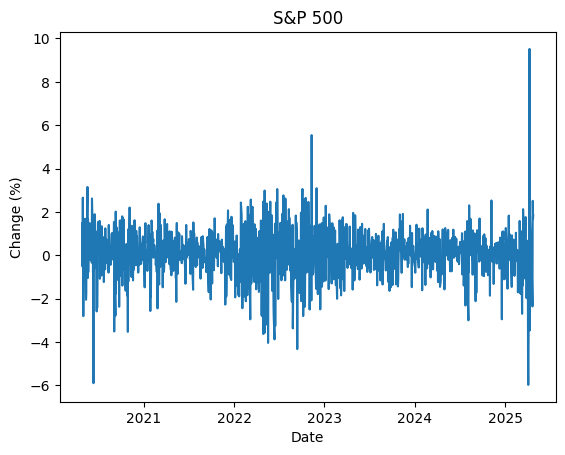

In [15]:
# graphing % change
historical = historical.reset_index()
X = pd.to_datetime(historical['Date'])
y = historical['Change']

plt.plot(X, y)
plt.title('S&P 500')
plt.xlabel('Date')
plt.ylabel('Change (%)')
plt.show()


In [16]:
# EDA

historical.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change
count,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03,1257.0,1257.0,1256.000000
mean,4430.272086,4456.206213,4402.660021,4431.030360,4.360416e+09,0.0,0.0,0.058738
std,773.337498,774.146732,771.583408,772.975551,9.805342e+08,0.0,0.0,1.129737
min,2794.540039,2842.709961,2766.639893,2820.000000,1.639500e+09,0.0,0.0,-5.974961
25%,3919.260010,3953.219971,3900.159912,3921.050049,3.775200e+09,0.0,0.0,-0.507433
50%,4332.740234,4362.120117,4300.729980,4330.000000,4.152090e+09,0.0,0.0,0.089549
75%,4856.799805,4868.410156,4844.049805,4850.430176,4.706290e+09,0.0,0.0,0.712420
max,6134.500000,6147.430176,6111.149902,6144.149902,9.976520e+09,0.0,0.0,9.515388


In [27]:
newsapi = NewsApiClient(api_key=apikey)

top_headlines = newsapi.get_top_headlines(q='market',
                                          category='business',
                                          language='en',
                                          country='us')

In [28]:
top_headlines

{'status': 'ok',
 'totalResults': 4,
 'articles': [{'source': {'id': 'the-washington-post',
    'name': 'The Washington Post'},
   'author': 'Jeff Stein, Andrew Ackerman, Dan Diamond',
   'title': 'Top Trump aides urged president to tone down attacks on Jerome Powell - The Washington Post',
   'description': 'The president’s about-face on the central bank chief, following advice from his treasury and commerce secretaries, sent markets surging.',
   'url': 'https://www.washingtonpost.com/business/2025/04/23/trump-backs-off-powell-attacks/',
   'urlToImage': 'https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/QYZPVSS4DASJSVF3DNU7ZNSC4I.JPG&w=1440',
   'publishedAt': '2025-04-23T17:56:18Z',
   'content': 'President Donald Trumps abrupt shift in rhetoric Tuesday toward Federal Reserve Chair Jerome H. Powell reflected the private lobbying of some of his senior advisers, who had urged the president to ba… [+6145 chars]'},

In [29]:
import requests

# url = 'https://newsapi.org/v2/top-headlines?country=us&category=business&apiKey=62638dc7df5e4e958183e238948a0ebf'
country = 'us'
category = 'business'

url = f"https://newsapi.org/v2/top-headlines?country={country}&category={category}&apiKey={apikey}"

response = requests.get(url)
data = response.json()

In [30]:
data

{'status': 'ok',
 'totalResults': 25,
 'articles': [{'source': {'id': None, 'name': 'Financial Times'},
   'author': 'Kana Inagaki, Aime Williams',
   'title': 'Donald Trump to exempt carmakers from some US tariffs - Financial Times',
   'description': 'President’s latest retreat follows intense lobbying by industry executives',
   'url': 'https://www.ft.com/content/fa0f6749-729e-41ca-917b-7b534041f6f8',
   'urlToImage': 'https://www.ft.com/__origami/service/image/v2/images/raw/https%3A%2F%2Fd1e00ek4ebabms.cloudfront.net%2Fproduction%2Fc1f969da-0fbe-425b-90b0-cff2801a294f.jpg?source=next-barrier-page',
   'publishedAt': '2025-04-23T20:17:04Z',
   'content': 'White House Watch newsletter\r\nSign up for your free, indispensable guide to what Trumps second term means for Washington, business and the world.'},
  {'source': {'id': None, 'name': 'CNBC'},
   'author': 'Amelia Lucas',
   'title': "Chipotle misses revenue estimates, gives more cautious outlook as it sees 'slowdown' in spending 

In [34]:
for article in data['articles']:
  headline = article['title']
  res = finbert(headline)
  print(headline,res)

Donald Trump to exempt carmakers from some US tariffs - Financial Times [{'label': 'neutral', 'score': 0.8605466485023499}]
Chipotle misses revenue estimates, gives more cautious outlook as it sees 'slowdown' in spending - CNBC [{'label': 'negative', 'score': 0.9404802322387695}]
Top Trump aides urged president to tone down attacks on Jerome Powell - The Washington Post [{'label': 'neutral', 'score': 0.7016040682792664}]
Elon Musk bankrolled a $100M climate contest. Now critics say it’s ‘tainted.’ - Politico [{'label': 'negative', 'score': 0.49005255103111267}]
Surveillance video shows New York-to-Paris flight stowaway slipping past gate agents - AP News [{'label': 'neutral', 'score': 0.87807697057724}]
Citadel's Ken Griffin warns Trump about tarnishing the 'brand' of U.S. Treasurys - CNBC [{'label': 'negative', 'score': 0.7564399838447571}]
China sends Boeing planes back to US over Trump tariffs - BBC [{'label': 'neutral', 'score': 0.8251573443412781}]
General Mills already tried natu